# Projeto 4: MPI
### Filipe F. Borba  
### Insper
### Super Computação, Prof. Igor Montagner


## Introdução

O problema explorado nesse projeto é o algoritmo do Caixeiro Viajante. Este problema encontra-se na área de Otimização discreta, que estuda problemas de otimização baseados em uma sequência de escolhas e que a solução ótima só pode ser encontrada se enumerarmos todas as escolhas possíveis. Em outras palavras, só conseguimos achar a solução ótima se tivermos todas as soluções possíveis. Assim, não existem algoritmos mais eficientes de resolução, pois todos tem complexidade O(2^n) ou pior.

Ao realizar esse teste das sequências de escolhas em paralelo, podemos diminuir consideravelmente o consumo de tempo do programa, o que é bastante interessante para a área de computacão paralela. Contudo, conseguimos potencializar ainda mais essa solução ao utilizar uma GPU que supera a CPU nesses casos, pois possui centenas de threads disponíveis para realizar os cálculos. Mais que isso, se utilizarmos uma série de computadores com GPU que conversam entre si via MPI, a performance escala exponencialmente.

O problema do Caixeiro Viajante é o seguinte:

<img src="https://camo.githubusercontent.com/a4d91635c96d345fc31068a4420834d23654f82b/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f7468756d622f312f31312f474c504b5f736f6c7574696f6e5f6f665f615f74726176656c6c696e675f73616c65736d616e5f70726f626c656d2e7376672f35313270782d474c504b5f736f6c7574696f6e5f6f665f615f74726176656c6c696e675f73616c65736d616e5f70726f626c656d2e7376672e706e67" alt="TSP" style="width: 300px;"/>

```Um vendedor possui uma lista de empresas que ele deverá visitar em um certo dia. Não existe uma ordem fixa: desde que todos sejam visitados seu objetivo do dia está cumprido. Interessado em passar o maior tempo possível nos clientes ele precisa encontrar a sequência de visitas que resulta no menor caminho.```

Para nosso projeto em específico, temos algumas simplificações:
- o nosso caixeiro usa Waze e já sabe qual é o caminho com a menor distância entre dois pontos;
- ele começa seu trajeto na empresa 0. Ou seja, basta ele encontrar um trajeto que passe por todas as outras e volte a empresa ```0```;
- ele não pode passar duas vezes na mesma empresa. Ou seja, a saída é uma permutação de ```0 ... (N-1)```



Finalmente, os objetivos deste projeto são

1. implementar uma versão ingênua do 2-opt utilizando MPI.
2. implementar a enumeração exaustiva utilizando MPI.

De maneira mais avançada, também temos:
3. implementar a enumeração exaustiva com branch and bound utilizando MPI.
4. implementar a enumeração exaustiva com branch and bound utilizando MPI e GPU.

** Como descrito em https://github.com/Insper/supercomp/blob/master/projeto-02/enunciado.md

## Organização do Projeto

O projeto foi realizado utilizando a linguagem C++ e o Boost MPI, juntamente com 3 máquinas t3.micro da AWS sem GPU. Temos, então, alguns arquivos diferentes.

* Arquivo 2opt_sol.cpp, que gera 10.000 soluções aleatórias, mas as otimiza utilizando a busca local 2-opt.
* Arquivo mpi-sol.cpp, que realiza a enumeração exaustiva com MPI.

Além disso, o projeto possui um CMakeLists.txt que possibilita a compilação dos executáveis. São eles:
* 2opt-spl (solução aleatória com otimização 2-opt)
* time-2opt_sol (com print de tempo - solução aleatória com otimização 2-opt)
* mpi-sol (solução de enumeração exaustiva)
* time-mpi-sol (com print de tempo - solução de enumeração exaustiva)

OBS: os outros executáveis foram criados para que a saída devolvesse o tempo, mas o código neles é igual.

Para compilar todos os executáveis, basta usar os seguintes comandos na pasta raíz do projeto:

```mkdir build; cd build; cmake ..; make ```

O comando ```make``` é responsável por compilar os executáveis.
Após isso, para iniciar cada executável, basta utilizar o comando 

```mpiexec -n 3 ./nome_do_arquivo < ../tests/nome_da_entrada```

dentro da pasta ```build```.

# Resultados

## Comparação com Sequencial sem MPI

O projeto em MPI possui poucas diferenças em relação ao projeto sequencial local. Podemos comparar com uma lista de prós e contras.

Projeto MPI:  
  
Vantagens:
- Ganho muito claro de desempenho por distribuir as tarefas entre várias máquinas.
- A complexidade de implementar o código em MPI sem passar mensagens não é tão grande.
- Escalabilidade imediata. (+ máquinas = + processamento!)

Desvantagens:
- Um código mais complexo (ex: branch and bound) pode ficar bem mais difícil de ser implementado.

Podemos então concluir que a implementação em MPI é bastante interessante, pois temos a solução ótima nesses casos. Contudo, ao adicionar mais complexidade ao código (Branch and Bound ou CUDA), pode ficar ainda mais difícil de implementar.

Vejamos como isso se comporta na prática:

In [1]:
%matplotlib inline
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

In [2]:
# Pegar o nome dos arquivos de saída
output = sorted([n for n in os.listdir("./output/")])
output

['time-2opt-sol-burma14',
 'time-2opt-sol-in10',
 'time-2opt-sol-ulysses16',
 'time-2opt-sol-ulysses22',
 'time-mpi-sol-burma14',
 'time-mpi-sol-in10',
 'time-tsp-seq-in10']

In [3]:
def print_file(file):
    with open("./output/" + file, 'r') as fin:
        print(f"-------{file}-------")
        print(fin.read())

In [4]:
for f in output:
    print_file(f)

-------time-2opt-sol-burma14-------
25
milisegundo(s).
30.87850 0
0 1 13 2 3 4 5 11 6 12 7 10 8 9 

-------time-2opt-sol-in10-------
20
milisegundo(s).
6303.41552 0
0 9 5 2 1 7 8 3 4 6 

-------time-2opt-sol-ulysses16-------
32
milisegundo(s).
74.75690 0
0 3 1 2 15 12 13 14 4 10 8 9 5 6 11 7 

-------time-2opt-sol-ulysses22-------
62
milisegundo(s).
77.77761 0
0 16 2 1 3 17 21 7 15 20 19 18 9 8 10 4 5 6 14 13 12 11 

-------time-mpi-sol-burma14-------
222300
milisegundo(s).
30.87850 1
0 9 8 10 7 12 6 11 5 4 3 2 13 1 

-------time-mpi-sol-in10-------
22
milisegundo(s).
6303.41552 1
0 9 5 2 1 7 8 3 4 6 

-------time-tsp-seq-in10-------
34
milisegundo(s).
6303.41552 1
0 9 5 2 1 7 8 3 4 6 



Dado que o tsp-seq e o mpi-sol encontram a solução ótima e realizam a enumeração exaustiva, enquanto que o 2opt-sol realiza sorteios e tenta verificar o melhor custo, teremos diferenças grandes de desempenho e precisão de resultado.

Como pode-se observar com as saídas dos testes, para a entrada in10, todos as soluções encontraram o caminho ótimo, assim validando os algoritmos em MPI. Contudo, para o burma14, podemos verificar a escala da diferença de desempenho. Enquanto o mpi-sol demora 222300 ms, o 2opt-sol demora apenas 20 ms.

Enquanto o 2opt-sol encontra soluções não-ótimas em alguns ms para o ulysses16 e ulysses22, o mpi-sol demora tanto que seu custo-benefício acaba sendo ínfimo.

Vamos comparar com a solução 2opt em apenas 1 GPU após verificar a diferença dessas soluções.

##  Testes de Desempenho

Aqui estamos preocupados com a diferença de desempenho. O tempo foi medido a partir da biblioteca <chrono> e o compilador mpicxx. Testaremos então o tempo de uma execução e a saída para as duas soluções (2opt e mpi). Para isso, existem alguns testes do TSPLIB já resolvidos que serão utilizados como base aqui. São eles:
- in10.txt (N = 10) // Pequeno
- burma14.txt (N = 14)   // Médio
- ulysses16.txt (N = 16)  // Grande
- ulysses22.txt (N = 22)   // Muito Grande

Esses testes foram escolhidos pois já representam uma grande diferença de desempenho entre os executáveis. 

In [5]:
def parse_output_file(file):
    with open("./output/" + file, 'r') as fin:
        output = fin.read().splitlines()
        input_file = file.split("-")[-1]
        executable = file.replace(f"-{input_file}", "")
        time = output[0]
        ms = output[1]
        best_cost = output[2][:-2]
        solution = output[3]
        return [executable, input_file, time, ms, best_cost, solution]

In [6]:
data = []
for f in output:
    data.append(parse_output_file(f))

In [7]:
df = pd.DataFrame(data, dtype=np.float64, columns=["Executavel", "Entrada", "Tempo", "ms",
                                                  "Melhor Custo", "Solucao"])
s = df["Entrada"].str.len().sort_values().index
df = df.reindex(s)
df = df.reset_index(drop=True)
df

,Executavel,Entrada,Tempo,ms,Melhor Custo,Solucao
0,time-2opt-sol,in10,20.0,milisegundo(s).,6303.41552,0 9 5 2 1 7 8 3 4 6
1,time-mpi-sol,in10,22.0,milisegundo(s).,6303.41552,0 9 5 2 1 7 8 3 4 6
2,time-tsp-seq,in10,34.0,milisegundo(s).,6303.41552,0 9 5 2 1 7 8 3 4 6
3,time-2opt-sol,burma14,25.0,milisegundo(s).,30.87850,0 1 13 2 3 4 5 11 6 12 7 10 8 9
4,time-mpi-sol,burma14,222300.0,milisegundo(s).,30.87850,0 9 8 10 7 12 6 11 5 4 3 2 13 1
5,time-2opt-sol,ulysses16,32.0,milisegundo(s).,74.75690,0 3 1 2 15 12 13 14 4 10 8 9 5 6 11 7
6,time-2opt-sol,ulysses22,62.0,milisegundo(s).,77.77761,0 16 2 1 3 17 21 7 15 20 19 18 9 8 10 4 5 6 14...


Verificando o dataframe, podemos observas que o tempo do mpi com enumeração exaustiva é muito inferior. E isso piora ainda mais com a adição de poucos pontos.

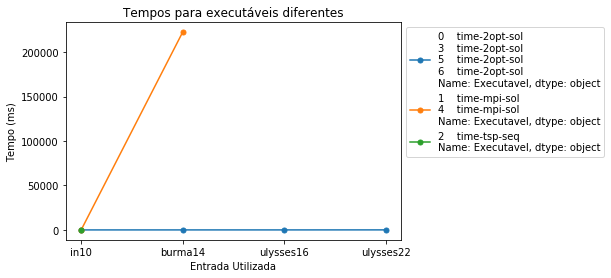

In [8]:
groups = df.groupby("Executavel")

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["Entrada"], group["Tempo"], marker='o', linestyle='-', ms=5, label=group["Executavel"])
plt.title('Tempos para executáveis diferentes')
plt.ylabel('Tempo (ms)')
plt.xlabel('Entrada Utilizada')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Como podemos verificar no gráficos acima, o algoritmo 2opt-sol tem um desempenho quase constante, que não piora tanto quando aumentam a quantidade de pontos. Contudo, isso afeta diretamente a qualidade da solução.

Por sua vez, o tempo mpi-sol aumenta DRASTICAMENTE de 10 pontos para 14, porém ele continua encontrando a solução ótima. Isso mostra que para poucos pontos a solução de enumeração exaustiva ingênua é aceitável, porém para mais pontos acaba sendo inviável.

Ao utilizar otimizações como o Branch and Bound, o desempenho do algoritmo será muito melhor, porém ainda não será tão boa quanto a solução em GPU como visto no [projeto 3](https://github.com/filipefborba/supercomp/blob/master/projeto-03/Filipe%20Borba%20-%20Projeto%203.ipynb).

A melhor opção dados todos os casos estudados seria utilizar GPU em conjunto com o MPI. Isso porque o desempenho da GPU é muito maior que soluções CPU. Nele, colocamos entradas de centenas de pontos e a qualidade do resultado é bastante aceitável, mesmo para o algoritmo 2opt.